In [1]:
from ats_models.longmbart.longformer_enc_dec import MLongformerEncoderDecoderForConditionalGeneration,MLongformerEncoderDecoderConfig

In [2]:
config = MLongformerEncoderDecoderConfig.from_pretrained("../../ats-models-custom-decoder/finetuned-mbart/baseline_fixed")
model = MLongformerEncoderDecoderForConditionalGeneration(config)

In [3]:
import torch
checkpoint = torch.load("/home/joehms/repos/ats-models-custom-decoder/finetuned-mbart/baseline_fixed/epoch=33_rougeL=0.20040.ckpt")

In [4]:
state_dict = checkpoint['state_dict']
aligned_state_dict = {}
for key, value in state_dict.items():
    aligned_state_dict[key.replace("model.","",1)] = state_dict[key]
aligned_state_dict['final_logits_bias'] = model.final_logits_bias
model.load_state_dict(aligned_state_dict)

<All keys matched successfully>

In [5]:
test_source = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/test.src"
test_target = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/test.trg"

train_source = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/train.src"
train_target = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/train.trg"

tokenizer_path = "../../ats-models-custom-decoder/modified-mbart"
max_input_length = 3072
max_output_length = 1024
beam_size = 4

In [6]:
from transformers import MBartTokenizer

tokenizer = MBartTokenizer.from_pretrained(tokenizer_path, use_fast=True)

In [7]:
from ats_models.data import CustomDataset, CustomDatasetForInference

In [8]:
test_set = CustomDatasetForInference(src_file=test_source,
                                     tgt_file=test_target,
                                     name="test",
                                     tokenizer=tokenizer,
                                     max_input_len=max_input_length,
                                     max_output_len=max_output_length,
                                     src_tags_included=True,
                                     tgt_tags_included=True)

train_set = CustomDataset(src_file=train_source,
                          tgt_file=train_target,
                          name="train",
                          tokenizer=tokenizer,
                          max_input_len=max_input_length,
                          max_output_len=max_output_length,
                          src_tags_included=True,
                          tgt_tags_included=True
            )

In [9]:
input_ids, ref, decoder_start_tokens = test_set[0]
input_ids, attention_mask = CustomDatasetForInference.prepare_input(input_ids.unsqueeze(dim=0), True, 'sliding_chunks', [512], 1, [-1])

decoder_start_tokens = 20030
torch.manual_seed(42)
generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                               use_cache=True, max_length=max_output_length,
                               pad_token_id=tokenizer.eos_token_id, decoder_start_token_id=decoder_start_tokens,
                               num_beams=beam_size,
                               penalty_alpha=0,
                               top_k=3,)

In [10]:
print("\nOUT: ", tokenizer.batch_decode(generated_ids))
print("\nGOLD: ", ref)


OUT:  ['de_SIMPLE Die Hochzeit von Timon und Ella ist ein halbes Jahr auseinander. Timon ist seit längerer Zeit unerfüllt. Timon ist unsicher, dass er nicht an die Hochzeit seiner Schwester mitnehmt.</s>']

GOLD:  Lars datet seit einiger Zeit Timon. Eigentlich wäre er "Boyfriend-Material", doch Lars fehlt etwas an ihm. Deshalb wollte Lars ihn auch nicht an die Hochzeit seiner Schwester mitnehmen. Nach kurzem Geschäker mit dem Hochzeitsfotografen fällt Lars auf, dass er diesen ganz süss findet und so landen die beiden im Bett. Wieder zu Hause angekommen, ist das Gespräch mit Timon unausweichlich. Zu Hause holt er sich Rat von Bruce und Ella.


In [ ]:
for key, value in data.items():
    data[key] = value.cpu().detach()
np.savez_compressed('cross_attn_maps', **data)

In [11]:
def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [21]:
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

#data_collator = CustomCollator(tokenizer=tokenizer, model=model, pad_to_multiple_of=8, padding=True)

batch_size = 2
data_loader =  iter(DataLoader(train_set, batch_size=batch_size, shuffle=False, collate_fn=CustomDataset.collate_fn(tokenizer)))

counter = 0
data = {}

import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()
    
for i in tqdm(range((int)(counter/batch_size), len(data_loader))):
    inputs = next(data_loader)
    input_ids, decoder_input_ids, labels = inputs['input_ids'], inputs['decoder_input_ids'], inputs['labels']
    bsz, seqlen = decoder_input_ids.size()
    input_ids, attention_mask = CustomDataset.prepare_input(input_ids, True, 'sliding_chunks', [512], tokenizer.pad_token_id, [-1])
    decoder_attention_mask = (decoder_input_ids != tokenizer.pad_token_id)

    with torch.no_grad():
        outputs = model(
                input_ids.to(device),
                attention_mask=attention_mask.to(device),
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=decoder_attention_mask.to(device),
                output_hidden_states=True,
                return_dict=True,
                output_attentions=True
                )
        last_cross_attn = outputs['cross_attentions'][-1]
        
        attn_mask = torch.bmm(decoder_attention_mask.float().unsqueeze(2), attention_mask.float().unsqueeze(1)).to(device)
        
        for batch_number  in range(0, bsz):
            current_mask = attention_mask[batch_number]
            current_decoder_mask = decoder_attention_mask[batch_number]
            
            current_attn_mask = attn_mask[batch_number]
            
            current_last_cross_attn =  last_cross_attn[batch_number][:,current_decoder_mask > 0,:][:,:,current_mask > 0]
            #current_inputs =  input_ids[batch_number][current_mask > 0]
            #current_decoder_input_ids = decoder_input_ids[batch_number][current_decoder_mask > 0]

            #print("\nattn size: ", current_last_cross_attn.size())
            #print("inputs size: ", current_inputs.size())
            #print("decoder size: ", current_decoder_input_ids.size())
            #print("Out: ", tokenizer.decode(current_decoder_input_ids))
            
            temperature = 1 / 14 # about same std as the original heads
            log_summation = torch.sum(torch.log(current_last_cross_attn), dim=0)
            #log_summation = torch.mul(log_summation, temperature)
            #log_summation = log_summation.masked_fill((1 - current_attn_mask).bool(), float('-inf'))
            #log_summation = torch.nn.functional.softmax(log_summation, dim=-1)
            #attn_min = 0
            attn_min = torch.min(torch.nan_to_num(log_summation, nan=0.0, neginf=0.0)).item()
            log_summation = torch.nan_to_num(log_summation, nan=0.0, neginf=attn_min)
            #log_summation = current_last_cross_attn[0]
            
            #print(current_last_cross_attn[0][0][-1])
            
            #attn_thr = log_summation.clone()
            #attn_thr[log_summation < 0.0015] = 0
            
            data['cross_attn_' + str(counter)] = log_summation.cpu().detach()
            counter += 1
            
            #mean = torch.mean(current_last_cross_attn, dim=0).cpu().detach().numpy()
            #plt.imshow(mean, aspect="auto")
            #plt.show()
            
np.savez_compressed('cross_attn_maps_all', **data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8953/8953 [57:48<00:00,  2.58it/s]


In [40]:
print(train_set[-1]['input_ids'].shape)
print(data['cross_attn_17904'].shape)
print(data['cross_attn_17904'][:,0])

torch.Size([225])
torch.Size([75, 226])
tensor([-171.5450,  -90.0222, -103.6556,  -95.7037, -101.4155,  -89.3273,
        -100.1605,  -97.4292,  -97.3064, -108.1203, -103.9149,  -99.8403,
        -103.8678,  -99.9361, -109.5296,  -85.1951,  -96.3924,  -92.2527,
         -84.9296,  -99.3273,  -86.9869, -104.7067, -100.9286, -107.9507,
         -99.6732, -100.8252,  -99.4199,  -98.3742, -111.1270, -102.9420,
        -108.3338,  -83.8268,  -88.8347,  -91.6204,  -92.8640,  -96.6875,
        -102.2097,  -96.1543, -105.9580, -101.0764, -109.9493, -102.4897,
         -95.7543, -108.1654,  -96.3269, -112.2721, -101.0693, -100.9542,
         -97.2065,  -99.9512, -113.0401, -117.9118,  -86.2042,  -97.7525,
        -107.7924, -122.7547, -108.6604, -106.6914, -108.0329, -104.2929,
        -105.4853,  -98.9829,  -95.2648, -103.7740,  -84.4245,  -84.5356,
         -88.3785,  -98.4426,  -92.8654, -100.0670, -101.9800, -102.5475,
        -104.5948,  -81.7236,  -84.3828])


/tmp/ipykernel_2106252/3029021608.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.imshow(torch.nn.functional.softmax(1/32 * data['cross_attn_17904'][:,0:10]), aspect="auto", cmap="viridis")


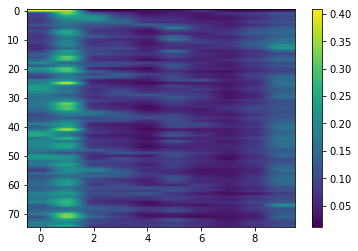

In [43]:
import matplotlib.pyplot as plt

plt.imshow(torch.nn.functional.softmax(1/32 * data['cross_attn_17904'][:,0:10]), aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

/tmp/ipykernel_2106252/2405044927.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.imshow(torch.nn.functional.softmax(1/100 * data['cross_attn_0'])[:,:], aspect="auto", cmap="viridis")


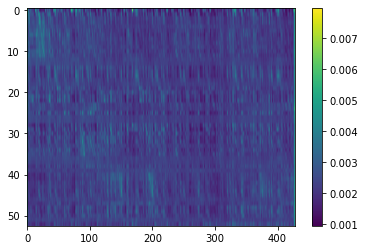

In [20]:
import matplotlib.pyplot as plt

plt.imshow(torch.nn.functional.softmax(1/100 * data['cross_attn_0'])[:,:], aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

In [15]:
#head 0 = 0.0162, 0.0438
#head 1 = 0.0045, 
#head 2 = 0.0111
#head 3 = 0.0114
#head 4 = 0.0108, 
#head 5 = 0.0117, 0.0244
#all 0.0120, 0.0307
torch.std(data['cross_attn_1'])

tensor(nan)

In [ ]:
import numpy as np
np.savez_compressed('cross_attn_12759', **data)

In [ ]:
import numpy as np
npzfile = np.load('test_8x12.npz')

In [ ]:
print("*" + tokenizer.decode(5, clean_up_tokenization_space=False) + "*")
attention_mask[0][:428]

In [ ]:
print(data['cross_attn_0'][0,:].shape)
torch.sum(data['cross_attn_0'][0,:])